In [1]:
from networkx.utils import powerlaw_sequence
import networkx as nx
import numpy as np
import random
import sys
import networkx as nx
import warnings as _warnings


In [74]:
def fixed_generate_community(number_of_communities, proba_inner, erdos_nodes_num = 100):
    list_of_communities = [nx.erdos_renyi_graph(erdos_nodes_num, proba_inner) for i in range(number_of_communities)]
    return list_of_communities

def unite_list_to_one(list_of_communities):
    current_graph = nx.Graph()
    if (len(list_of_communities) != 0):
        current_graph = list_of_communities[0]

    for i in range(1,len(list_of_communities)):
        current_graph = nx.disjoint_union(current_graph, list_of_communities[i])
    
    return current_graph 

def connect_communities_by_edge(graph_with_isolated_components, G_configurated_no_comm, erdos_nodes_num = 100):
    count_edges_avg_outer_deg = np.array([0 for i in range(len(graph_with_isolated_components))]) #array for computing average outer degree (between communities) 
    for u,v in G_configurated_no_comm.edges():
        i = np.random.choice(erdos_nodes_num-1)
        j = np.random.choice(erdos_nodes_num-1)
        graph_with_isolated_components.add_edge(erdos_nodes_num*u + i, erdos_nodes_num*v + j)
        count_edges_avg_outer_deg[erdos_nodes_num*u + i] += 1
        count_edges_avg_outer_deg[erdos_nodes_num*v + j] += 1
    #average_degree = len(np.nonzero(count_edges_avg_outer_deg)[0])/np.sum(count_edges_avg_outer_deg)
    #for i in range(number_of_communities - 1):
    #    graph_with_isolated_components.add_edge(20*i, 20*(i+1)) #100 is equal to number of nodes in one component
    return graph_with_isolated_components #, average_degree


#The code below in this cell is taken from previous implementation of networkx 
def create_degree_sequence(n, sfunction=None, max_tries=50, **kwds):
    _warnings.warn("create_degree_sequence() is deprecated",
                   DeprecationWarning)
    """ Attempt to create a valid degree sequence of length n using
    specified function sfunction(n,**kwds).

    Parameters
    ----------
    n : int
        Length of degree sequence = number of nodes
    sfunction: function
        Function which returns a list of n real or integer values.
        Called as "sfunction(n,**kwds)".
    max_tries: int
        Max number of attempts at creating valid degree sequence.

    Notes
    -----
    Repeatedly create a degree sequence by calling sfunction(n,**kwds)
    until achieving a valid degree sequence. If unsuccessful after
    max_tries attempts, raise an exception.
    
    For examples of sfunctions that return sequences of random numbers,
    see networkx.Utils.

    Examples
    --------
    >>> from networkx.utils import uniform_sequence, create_degree_sequence
    >>> seq=create_degree_sequence(10,uniform_sequence)
    """
    tries=0
    max_deg=n
    while tries < max_tries:
        trialseq=sfunction(n,**kwds)
        # round to integer values in the range [0,max_deg]
        seq=[min(max_deg, max( int(round(s)),0 )) for s in trialseq]
        # if graphical return, else throw away and try again
        if is_valid_degree_sequence(seq):
            return seq
        tries+=1
    raise nx.NetworkXError(\
          "Exceeded max (%d) attempts at a valid sequence."%max_tries)

def is_valid_degree_sequence_erdos_gallai(deg_sequence):
    """Returns True if deg_sequence is a valid degree sequence.
    
    A degree sequence is valid if some graph can realize it. 
    Validation proceeds via the Erdős-Gallai algorithm.
    
    Worst-case run time is: O( n**2 )
    
    Parameters
    ----------
    deg_sequence : list
        A list of integers where each element specifies the degree of a node
        in a graph.

    Returns
    -------
    valid : bool
        True if deg_sequence is a valid degree sequence and False if not.
    
    References
    ----------
    [EG1960]_, [choudum1986]_    

    """
    # some simple tests 
    if deg_sequence==[]:
        return True # empty sequence = empty graph 
    if not nx.utils.is_list_of_ints(deg_sequence):
        return False   # list of ints
    if min(deg_sequence)<0:
        return False      # each int not negative
    if sum(deg_sequence)%2:
        return False      # must be even

    n = len(deg_sequence)
    deg_seq = sorted(deg_sequence,reverse=True)
    sigk = [i for i in range(1, len(deg_seq)) if deg_seq[i] < deg_seq[i-1]]
    for k in sigk:
        sum_deg = sum(deg_seq[0:k])
        sum_min = k*(k-1) + sum([min([k,deg_seq[i]]) 
                                 for i in range(k,n)])
        if sum_deg>sum_min:
            return False
    return True

def is_valid_degree_sequence_havel_hakimi(deg_sequence):
    """Returns True if deg_sequence is a valid degree sequence.
    
    A degree sequence is valid if some graph can realize it. 
    Validation proceeds via the Havel-Hakimi algorithm.
    
    Worst-case run time is: O( n**(log n) )
    
    Parameters
    ----------
    deg_sequence : list
        A list of integers where each element specifies the degree of a node
        in a graph.

    Returns
    -------
    valid : bool
        True if deg_sequence is a valid degree sequence and False if not.
    
    References
    ----------
    [havel1955]_, [hakimi1962]_, [CL1996]_
    
    """
    # some simple tests 
    if deg_sequence==[]:
        return True # empty sequence = empty graph 
    if not nx.utils.is_list_of_ints(deg_sequence):
        return False   # list of ints
    if min(deg_sequence)<0:
        return False      # each int not negative
    if sum(deg_sequence)%2:
        return False      # must be even
    
    # successively reduce degree sequence by removing node of maximum degree
    # as in Havel-Hakimi algorithm
        
    s=deg_sequence[:]  # copy to s
    while s:      
        s.sort()    # sort in increasing order
        if s[0]<0: 
            return False  # check if removed too many from some node

        d=s.pop()             # pop largest degree 
        if d==0: return True  # done! rest must be zero due to ordering

        # degree must be <= number of available nodes
        if d>len(s):   return False

        # remove edges to nodes of next higher degrees
        #s.reverse()  # to make it easy to get at higher degree nodes.
        for i in range(len(s)-1,len(s)-(d+1),-1):
            s[i]-=1

    # should never get here b/c either d==0, d>len(s) or d<0 before s=[]
    return False

def is_valid_degree_sequence(deg_sequence, method='hh'):
    """Returns True if deg_sequence is a valid degree sequence.
    
    A degree sequence is valid if some graph can realize it.
    
    Parameters
    ----------
    deg_sequence : list
        A list of integers where each element specifies the degree of a node
        in a graph.
    method : "eg" | "hh"
        The method used to validate the degree sequence.  
        "eg" corresponds to the Erdős-Gallai algorithm, and 
        "hh" to the Havel-Hakimi algorithm.

    Returns
    -------
    valid : bool
        True if deg_sequence is a valid degree sequence and False if not.
    
    References
    ----------
    Erdős-Gallai
        [EG1960]_, [choudum1986]_
    
    Havel-Hakimi
        [havel1955]_, [hakimi1962]_, [CL1996]_
    
    """
    if method == 'eg':
        valid = is_valid_degree_sequence_erdos_gallai(deg_sequence)
    elif method == 'hh':
        valid = is_valid_degree_sequence_havel_hakimi(deg_sequence)
    else:
        msg = "`method` must be 'eg' or 'hh'"
        raise nx.NetworkXException(msg)
    
    return valid

2000


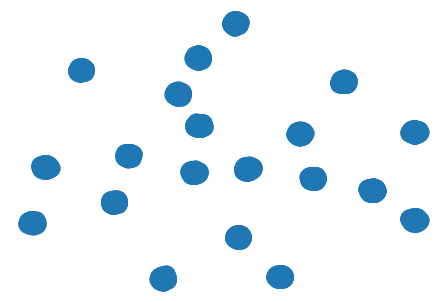

In [18]:
import matplotlib.pyplot as plt
Graphs_array = fixed_generate_community(20, 0.8)
G1 = unite_list_to_one(Graphs_array)
print(len(G1.nodes()))
nx.draw(G1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: create_degree_sequence() is deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


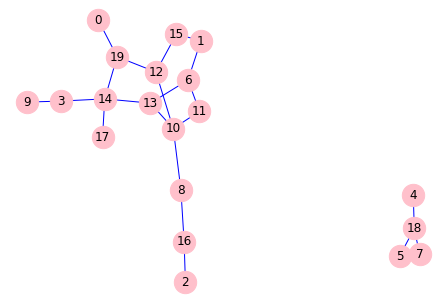

In [16]:
z = create_degree_sequence(20, powerlaw_sequence)
G1_configurated = nx.configuration_model(z)
nx.draw(G1_configurated, with_labels=True, node_color='pink', node_size=500, edge_color='blue')

In [51]:
def generate_powerlaw_partial(Graph, percentage):
    if percentage > 1 or percentage < 0:
        print('Enter percentage between 0 and 1')
        return
    
    nodes_in_subgraph = []

    arr_of_nodes = np.array(list(Graph.nodes()))
    number_of_vertices = int(len(Graph.nodes())*percentage)
    for i in range(number_of_vertices):
        elem = np.random.choice(arr_of_nodes)             
        nodes_in_subgraph.append(elem)
        tmp_res = np.where(arr_of_nodes == elem)
        arr_of_nodes = np.delete(arr_of_nodes, tmp_res[0][0])
    x = create_degree_sequence(number_of_vertices, powerlaw_sequence)
    G_subgraph_percentage = nx.configuration_model(x)
    return G_subgraph_percentage, nodes_in_subgraph

def relabelling_nodes(Graph, list_for_mapping):
    G_relabelled = nx.relabel_nodes(Graph, dict(zip(list(Graph.nodes()), list_for_mapping)))
    return G_relabelled

def merge_relabelled_with_erdos_communities(G_relabelled_partial, G_erdos_communities):
    for (u,v) in G_relabelled_partial.edges():
        if (u,v) not in G_erdos_communities.edges():
            G_erdos_communities.add_edge(u,v)
    return G_erdos_communities 

def generate_ensemble(size_of_ensemble = 100, probability_of_erdos = 0.8, erdos_size = 20, percentage_of_partial = 0.1):
    ensemble = []
    for i in range(size_of_ensemble):
        Graphs_array = fixed_generate_community(erdos_size, probability_of_erdos)
        G1 = unite_list_to_one(Graphs_array)
        G2_gen_ten, nodes_in_G2 = generate_powerlaw_partial(G1, percentage_of_partial)
        G3 = relabelling_nodes(G2_gen_ten, nodes_in_G2)
        G4_merged = merge_relabelled_with_erdos_communities(G3, G1)
        ensemble.append(G4_merged)
    return ensemble

In [76]:
#10 percent graph
G2_generated_ten_percents, nodes_in_G2_gen = generate_powerlaw_partial(G1, 0.1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: create_degree_sequence() is deprecated


In [33]:
G_test = relabelling_nodes(G2_generated_ten_percents, nodes_in_G2_gen)
G_test.nodes(), len(G_test.nodes())

(NodeView((44, 1789, 681, 1521, 241, 1821, 1684, 1650, 1270, 902, 1704, 1446, 1642, 1042, 123, 1020, 675, 1714, 1627, 420, 895, 793, 757, 456, 940, 1197, 1122, 475, 982, 504, 165, 310, 325, 439, 1671, 161, 1125, 1469, 1935, 652, 1617, 1613, 728, 727, 1351, 547, 1632, 886, 376, 737, 1030, 712, 1900, 988, 15, 926, 119, 156, 1921, 1090, 1773, 1215, 1149, 1760, 57, 1472, 933, 1386, 581, 1461, 381, 1708, 995, 1177, 1352, 379, 1701, 292, 1732, 1103, 273, 617, 1753, 1771, 1991, 1606, 1488, 1259, 1082, 768, 1783, 1217, 319, 1673, 1503, 629, 1454, 300, 152, 786, 330, 1175, 343, 489, 1838, 702, 1870, 884, 1611, 1576, 1028, 1374, 395, 463, 1267, 548, 709, 1955, 1943, 1165, 1590, 1575, 824, 1221, 1186, 1275, 1112, 484, 1950, 340, 713, 432, 661, 847, 638, 1359, 1880, 1174, 599, 1210, 615, 756, 1585, 1060, 173, 942, 451, 1882, 842, 1841, 1375, 1706, 904, 1162, 1830, 1903, 1397, 1780, 1876, 860, 41, 1666, 518, 1049, 1922, 1467, 402, 191, 856, 1007, 227, 745, 1552, 1227, 739, 1675, 1414, 659, 87, 866,

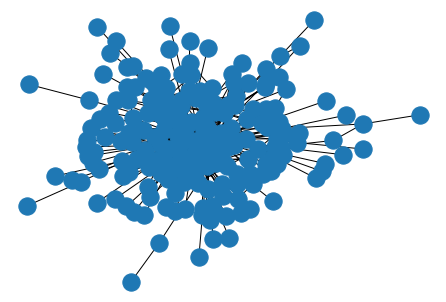

In [35]:
nx.draw(G_test)

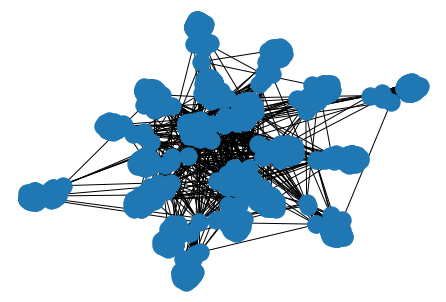

In [36]:
G1_merged = merge_relabelled_with_erdos_communities(G_test, G1)
nx.draw(G1_merged)

In [38]:
def inner_neighbors(Graph, vertex, node_number_in_one_community):
    vertex_neighbors = [u for u in Graph.neighbors(vertex)]
    number_of_community = vertex // node_number_in_one_community + 1
    inner_neighbors = []
    for n in vertex_neighbors:
        if (n // node_number_in_one_community + 1) == number_of_community:
            inner_neighbors.append(n)
    return inner_neighbors


def outer_neighbors(Graph, vertex, node_number_in_one_community):
    vertex_neighbors = [u for u in Graph.neighbors(vertex)]
    number_of_community = vertex // node_number_in_one_community + 1
    outer_neighbors = []
    for n in vertex_neighbors:
        if (n // node_number_in_one_community + 1) != number_of_community:
            outer_neighbors.append(n)
    return outer_neighbors
    

In [39]:
inner_degrees = []
nodes = []
for i in G1_merged.nodes():
    nodes.append(i)
    inner_degrees.append(len(inner_neighbors(G1_merged, i, 100)))


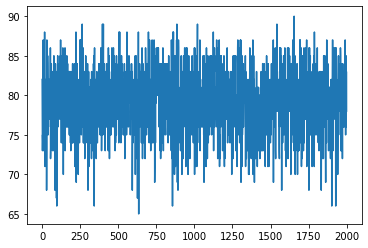

In [40]:
plt.plot(nodes, inner_degrees)

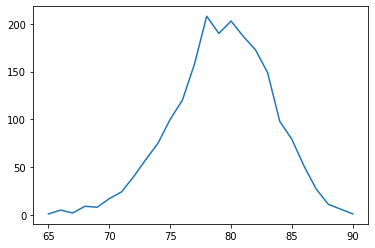

In [41]:
nod_and_deg = dict(zip(nodes, inner_degrees))
sorted_nod_and_deg = dict(sorted(nod_and_deg.items(), key=lambda item: item[1]))
nodes = [node for node in  sorted_nod_and_deg.keys()]
inner_degrees = [deg for deg in  sorted_nod_and_deg.values()]
y = [i for i in inner_degrees]
unique, counts = np.unique(y, return_counts=True)
plt.plot(unique,counts)
#plt.plot(nodes, inner_degrees)

In [42]:
outer_degrees = []
nodes = []
for i in G1_merged.nodes():
    nodes.append(i)
    outer_degrees.append(len(outer_neighbors(G1_merged, i, 100)))

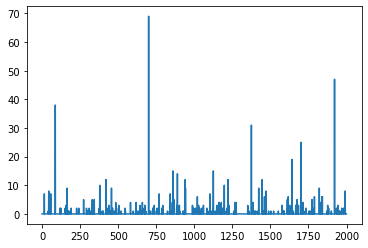

In [43]:
plt.plot(nodes, outer_degrees)

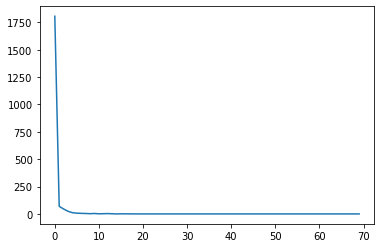

In [44]:
nod_and_deg = dict(zip(nodes, outer_degrees))
sorted_nod_and_deg = dict(sorted(nod_and_deg.items(), key=lambda item: item[1]))
nodes = [node for node in  sorted_nod_and_deg.keys()]
outer_degrees = [deg for deg in  sorted_nod_and_deg.values()]
y = [i for i in outer_degrees]
unique, counts = np.unique(y, return_counts=True)
plt.plot(unique,counts)

Text(0, 0.5, '$\\rho$')

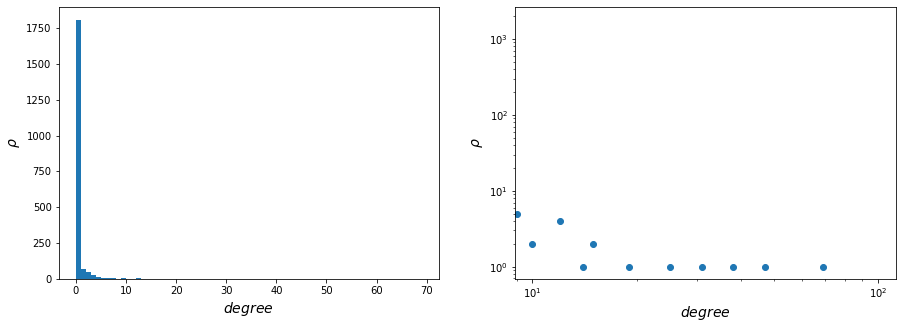

In [45]:
degrees=outer_degrees
ro=np.bincount(degrees)
x=np.nonzero(ro)
y=ro[np.nonzero(ro)]

fig, ax = plt.subplots(nrows=1, sharey=False,ncols=2, figsize=(15, 5))
ax[0].hist(degrees, bins=max(degrees)-min(degrees))
ax[0].set_xlabel(r'$ degree$', fontsize=14)
ax[0].set_ylabel(r'$\rho$', fontsize=14)

ax[1].scatter(x,y)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$ degree$', fontsize=14)
ax[1].set_ylabel(r'$\rho$', fontsize=14)

In [46]:
nodes = [node for node in  dict(G1_merged.degree(G1_merged.nodes())).keys()]
degrees = [deg for deg in  dict(G1_merged.degree(G1_merged.nodes())).values()]

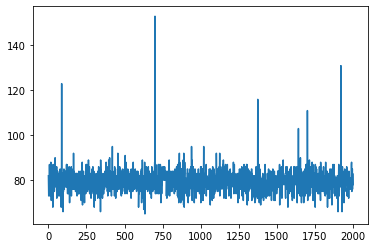

In [47]:
plt.plot(nodes, degrees)

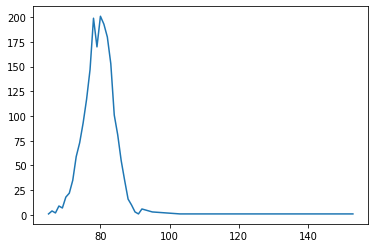

In [48]:
#plot distribution
nod_and_deg = dict(zip(nodes, degrees))
sorted_nod_and_deg = dict(sorted(nod_and_deg.items(), key=lambda item: item[1]))
nodes = [node for node in  sorted_nod_and_deg.keys()]
degrees = [deg for deg in  sorted_nod_and_deg.values()]
y = [i for i in degrees]
unique, counts = np.unique(y, return_counts=True)
plt.plot(unique,counts)

In [52]:
ensemble = generate_ensemble()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: create_degree_sequence() is deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


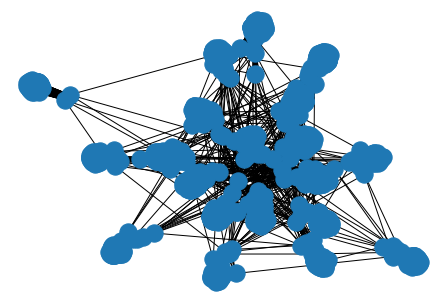

In [54]:
nx.draw(ensemble[0])